<a href="https://colab.research.google.com/github/TamiHime/Si_Graphite/blob/main/Si_Graphite_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyBaMM and required dependencies
!pip install -q git+https://github.com/pybamm-team/PyBaMM.git@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

PyBaMM can collect usage data and send it to the PyBaMM team to help us improve the software.
We do not collect any sensitive information such as models, parameters, or simulation results - only information on which parts of the code are being used and how frequently.
This is entirely optional and does not impact the functionality of PyBaMM.
For more information, see https://docs.pybamm.org/en/latest/source/user_guide/index.html#telemetry
Do you want to enable telemetry? (Y/n): Y

Telemetry enabled.



In [8]:
import timeit
#Define the composite model
start = timeit.default_timer()

model = pybamm.lithium_ion.DFN(
    {
        "particle phases": ("2", "1"), #Silicon, Graphite Particles
        "open-circuit potential":(("single", "current sigmoid"),"single"),
    }
)

#Use Chen 2020 parameter set
param = pybamm.ParameterValues("Chen2020_composite")

param.update({ "Upper voltage cut-off [V]": 4.5})
param.update({ "Lower voltage cut-off [V]": 2.5})

param.update(
    {
        "Primary: Maximum concentration in negative electrode [mol.m-3]": 28700,
        "Primary: Initial concentration in negative electrode [mol.m-3]": 23000,
        "Primary: Negative particle diffusivity [m2.s-1]": 5.5e-14,
        "Secondary: Negative particle diffusivity [m2.s-1]": 1.67e-14,
        "Secondary: Initial concentration in negative electrode [mol.m-3]": 277000,
        "Secondary: Maximum concentration in negative electrode [mol.m-3]": 278000,
    }
)

In [9]:
#Define current loading

C_rate = 0.5
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rate * capacity

t_eval = np.linspace(0, 10000, 1000)

param["Current function [A]"] = I_load

In [22]:
v_si = [0.001, 0.5, 0.9]
total_am_volume_fraction = 0.95
solution = []
for v in v_si:
    param.update(
        {
            "Primary: Negative electrode active material volume fraction": (1 - v)
            * total_am_volume_fraction,  # primary
            "Secondary: Negative electrode active material volume fraction": v
            * total_am_volume_fraction,
        }
    )
    print(v)
    sim = pybamm.Simulation(
        model,
        parameter_values=param,
        solver=pybamm.CasadiSolver(dt_max=5),
    )
    solution.append(sim.solve(t_eval=t_eval))
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

0.001
0.5


At t = 7.51703, repeated recoverable residual errors.
At t = 2.46198 and h = 2.34677e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.46197 and h = 7.35638e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.19822 and h = 9.14575e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.566291 and h = 1.73624e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.2504 and h = 1.98182e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0923903 and h = 9.72464e-20, the corrector convergence failed repeatedly or with |h| = hmin.


0.9


At t = 7.51703 and h = 1.30906e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.46199 and h = 1.41664e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2.46197 and h = 1.04461e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.19822 and h = 1.08043e-27, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.566343 and h = 7.80485e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.250399 and h = 1.86113e-13, the corrector convergence failed repeatedly or with |h| = hmin.


running time: 668.3558534439999s


At t = 0.0924335 and h = 1.10986e-14, the corrector convergence failed repeatedly or with |h| = hmin.


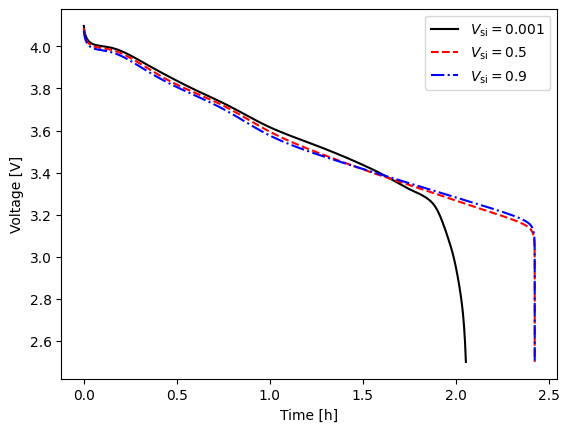

In [23]:
ltype = ["k-", "r--", "b-.", "g:", "m-", "c--", "y-."]
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    V_i = solution[i]["Voltage [V]"].entries
    plt.plot(t_i, V_i, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Voltage [V]")
plt.legend()

In [24]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/2 until 3.0 V",
            "Rest for 1 hour",
            "Charge at C/2 until 4.2 V",
            "Rest for 1 hour",
        ),
    ]
    * 2
)

In [25]:
solution = []
for v in v_si:
    param.update(
        {
            "Primary: Negative electrode active material volume fraction": (1 - v)
            * total_am_volume_fraction,  # primary
            "Secondary: Negative electrode active material volume fraction": v
            * total_am_volume_fraction,
        }
    )
    print(v)
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        parameter_values=param,
        solver=pybamm.CasadiSolver(dt_max=5),
    )
    solution.append(sim.solve(calc_esoh=False))
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

0.001
0.5


At t = 26.2358 and h = 5.20822e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 26.2357 and h = 4.21839e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 11.0858 and h = 1.54265e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.51076 and h = 2.29859e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.51076 and h = 1.12378e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.61701 and h = 2.0526e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 22.8809 and h = 5.79439e-22, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 22.8809 and h = 1.70059e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 7.73095 and h = 2.39961e-19, the corrector convergence failed repeatedly or with |h| = hmin.


0.9


At t = 26.2357 and h = 9.5034e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 26.2358 and h = 1.44096e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 11.0857 and h = 2.3667e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.51074 and h = 4.19076e-20, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3.51075 and h = 2.23465e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 1.61699 and h = 2.91467e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.670113 and h = 8.80105e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 40.9868 and h = 4.50927e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 10.6868 and h = 6.52126e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 10.6868 and h = 1.06933e-14, the corrector convergence failed repeatedly or with |h| = hmin.
A

running time: 735.6504843980001s


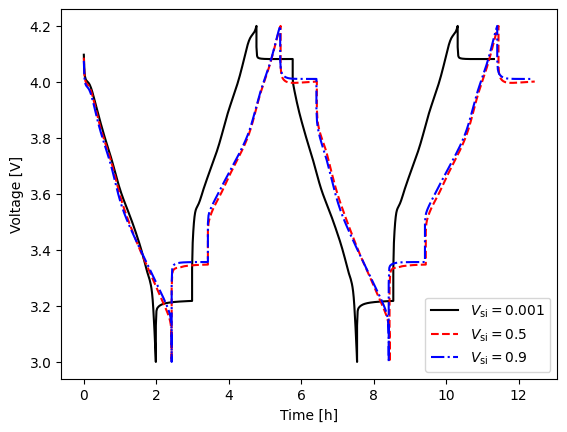

In [26]:
ltype = ["k-", "r--", "b-.", "g:", "m-", "c--", "y-."]
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    V_i = solution[i]["Voltage [V]"].entries
    plt.plot(t_i, V_i, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Voltage [V]")
plt.legend()

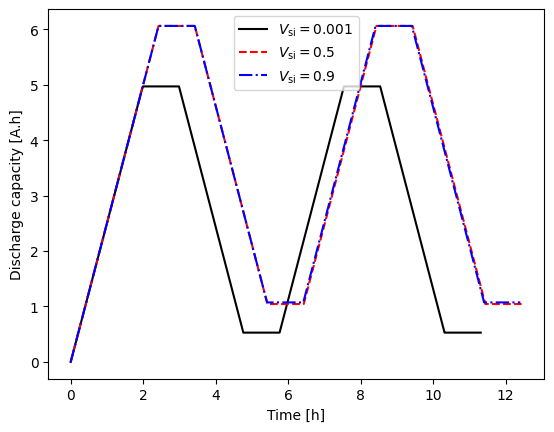

In [28]:
ltype = ["k-", "r--", "b-.", "g:", "m-", "c--", "y-."]
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    C_i = solution[i]["Discharge capacity [A.h]"].entries
    plt.plot(t_i, C_i, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()